# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [45]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

# [Teacher's libraries imports]
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip

pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [2]:
# [Teacher's code]
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

rncp.head()

,Categorie,text_certifications
0,1,Responsable de chantiers de bûcheronnage manue...
1,1,Responsable de chantiers de bûcheronnage manue...
2,1,Travaux forestiers
3,1,Forêt
4,1,Forêt


In [3]:
# [Teacher's code]
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
# [Professor's code]
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
# [Teacher's code]
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [15]:
# [Teacher's comment] This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 1
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 94312


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [16]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced, labels_reduced, test_size=0.25, random_state=0)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [23]:
# First try: tokenization with nltk
tokenized_train_texts = [word_tokenize(text) for text in train_texts]
tokenized_test_texts = [word_tokenize(text) for text in test_texts]

tokenized_train_texts[:2]

[['Maître-chien', 'en', 'sécurité', 'privée'],
 ['Ingénieur',
  'diplômé',
  'de',
  "l'Ecole",
  'nationale',
  'supérieure',
  'des',
  'techniques',
  'industrielles',
  'et',
  'des',
  'mines',
  'de',
  'Douai',
  '(',
  'ENSTIMD',
  ')',
  ',',
  'spécialité',
  'Productique']]

<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
# [Teacher's comment] Look at the data and apply the appropriate pre-processing

# Second try: tokenization with a custom function
def clean_and_tokenize(text):    
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

tokenized_train_texts = [clean_and_tokenize(text) for text in train_texts]
tokenized_test_texts = [clean_and_tokenize(text) for text in test_texts]

tokenized_train_texts[:2]

[['maître', 'chien', 'sécurité', 'privée'],
 ['ingénieur',
  'diplômé',
  'lecole',
  'nationale',
  'supérieure',
  'des',
  'techniques',
  'industrielles',
  'des',
  'mines',
  'douai',
  'enstimd',
  'spécialité',
  'productique']]

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [32]:
def count_words(texts, voc = None):
    """
    Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray(n_samples, n_features)
        The counts of each word in each text.
    """
    
    if voc == None:
        vocabulary = {}
         
        # List of all words in the texts
        words = []
        for text in texts:
            # Clean and tokenize the text
            tokens = clean_and_tokenize(text)
            # Add the list of tokens to the list of words
            words.append(tokens)

        # Flatten the list of lists into a single list of words
        flat_words = [token for sublist in words for token in sublist]
        
        # Creation of the set of all words in the texts
        words = set(flat_words)
        
        # Creation of the vocabulary
        for word in words:
            if word not in vocabulary:
                vocabulary[word] = len(vocabulary)
    else:
        vocabulary = voc
    
    # Creation of the Count Matrix
    counts = np.zeros((len(texts), len(vocabulary)))
    for i, text in enumerate(texts):
        tokens = clean_and_tokenize(text)
        for token in tokens:
            if token in vocabulary:
                counts[i, vocabulary[token]] += 1
        
    
    return vocabulary, counts

In [33]:
vocabulary, bag_of_words = count_words(train_texts)

# print("\nVocabulary:\n", vocabulary)
print("\nBag-of-words:\n", bag_of_words)


Bag-of-words:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [37]:
# Create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
vectorizer_train_bow = vectorizer.fit_transform(train_texts).toarray()

print(vectorizer_train_bow.shape)

(70734, 5350)


In [38]:
# Transform the test data
vectorizer_test_bow = vectorizer.transform(test_texts).toarray()
print(vectorizer_test_bow.shape)

(23578, 5350)


Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.22      0.22      2953
          10       0.27      0.12      0.17      1594
          11       0.17      0.09      0.12       962
          12       0.15      0.13      0.14       394
          13       0.21      0.21      0.21       388
          14       0.26      0.24      0.25       711
          15       0.11      0.04      0.06       910
          16       0.19      0.24      0.21      2889
           2       0.26      0.17      0.20       307
           3       0.33      0.24      0.28       937
           4       0.31      0.52      0.39      4871
           5       0.10      0.05      0.06      1275
           6       0.19      0.07      0.11      1251
           7       0.21      0.18      0.19      2003
           8       0.26      0.18      0.21       375
           9       0.28      0.27      0.27      1758

    accuracy                           0.25     23578
   

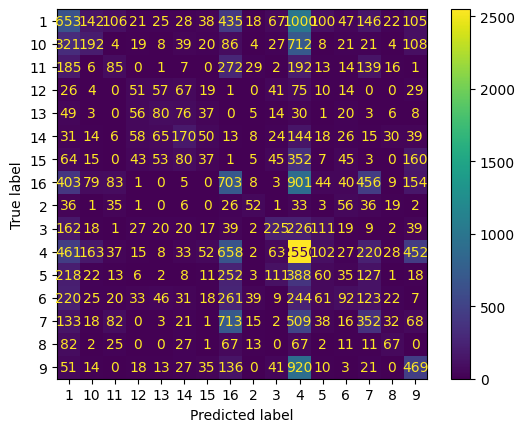

In [49]:
# Fit the model on the training data
pipeline_count = Pipeline([
    ('vectorize', CountVectorizer()),
    ('regression', LogisticRegression(max_iter=1000000000)),
])

pipeline_count.fit(train_texts, train_labels)
test_pred_count = pipeline_count.predict(test_texts)

print("Classification Report:")
print(classification_report(test_labels, test_pred_count))

classes = pipeline_count.named_steps['regression'].classes_

conf_mat = confusion_matrix(test_labels, test_pred_count, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot()

Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.24      0.23      2953
          10       0.34      0.11      0.17      1594
          11       0.20      0.10      0.13       962
          12       0.18      0.16      0.17       394
          13       0.24      0.19      0.21       388
          14       0.27      0.24      0.26       711
          15       0.12      0.05      0.08       910
          16       0.20      0.29      0.24      2889
           2       0.29      0.15      0.20       307
           3       0.32      0.24      0.28       937
           4       0.32      0.53      0.40      4871
           5       0.13      0.05      0.07      1275
           6       0.20      0.07      0.11      1251
           7       0.22      0.17      0.19      2003
           8       0.28      0.17      0.21       375
           9       0.30      0.28      0.29      1758

    accuracy                           0.26     23578
   

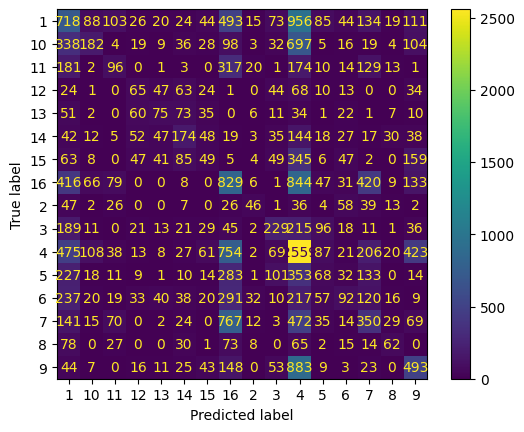

In [47]:
# Re-execute with TF-IDF
pipeline_tfidf = Pipeline([
    ('vectorize', TfidfVectorizer()),
    ('regression', LogisticRegression(max_iter=1000000000)),
])

pipeline_tfidf.fit(train_texts, train_labels)
test_pred_tfidf = pipeline_tfidf.predict(test_texts)

print("Classification Report:")
print(classification_report(test_labels, test_pred_tfidf))

classes = pipeline_tfidf.named_steps['regression'].classes_

conf_mat = confusion_matrix(test_labels, test_pred_tfidf, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot()

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [64]:
pipeline_svd = Pipeline([
    ('vectorize', TfidfVectorizer(sublinear_tf=True, use_idf=True)),
    ('svd', TruncatedSVD(n_components=300, random_state=42)),
    ('regression', LogisticRegression(max_iter=1000000000)),
])

pipeline_svd.fit(train_texts, train_labels)
test_pred_svd = pipeline_svd.predict(test_texts)

print("Classification Report:")
print(classification_report(test_labels, test_pred_svd))

Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.26      0.24      2953
          10       0.34      0.09      0.14      1594
          11       0.23      0.10      0.14       962
          12       0.19      0.12      0.14       394
          13       0.24      0.15      0.19       388
          14       0.20      0.16      0.18       711
          15       0.18      0.06      0.09       910
          16       0.23      0.31      0.26      2889
           2       0.25      0.09      0.13       307
           3       0.28      0.19      0.23       937
           4       0.31      0.58      0.40      4871
           5       0.17      0.06      0.09      1275
           6       0.22      0.09      0.13      1251
           7       0.24      0.18      0.21      2003
           8       0.29      0.14      0.19       375
           9       0.31      0.26      0.28      1758

    accuracy                           0.27     23578
   

In [67]:
pipeline_lda = Pipeline([
    ('vectorize', CountVectorizer()),
    ('lda', LatentDirichletAllocation(
        n_components=300, 
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
        random_state=0
    )),
    ('regression', LogisticRegression(max_iter=1000000000)),
])

pipeline_lda.fit(train_texts, train_labels)
test_pred_lda = pipeline_lda.predict(test_texts)

print("Classification Report:")
print(classification_report(test_labels, test_pred_lda))

Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.24      0.23      2953
          10       0.29      0.03      0.06      1594
          11       0.20      0.02      0.04       962
          12       0.16      0.09      0.11       394
          13       0.20      0.12      0.15       388
          14       0.21      0.11      0.14       711
          15       0.18      0.05      0.08       910
          16       0.22      0.34      0.27      2889
           2       0.00      0.00      0.00       307
           3       0.27      0.16      0.20       937
           4       0.29      0.63      0.39      4871
           5       0.20      0.05      0.08      1275
           6       0.18      0.05      0.07      1251
           7       0.21      0.12      0.15      2003
           8       0.31      0.06      0.11       375
           9       0.27      0.21      0.23      1758

    accuracy                           0.25     23578
   

C:\Users\João Melga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\João Melga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\João Melga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classif

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [ ]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = ...
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = ...
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = ...                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = ...
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                ...
                ...
    return M  

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension


<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = ... # Indexes of words in the sentence obtained thanks to the vocabulary
        sentrep = ... # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Obtain document representations, apply the classifier


## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = [...]

In [ ]:
model.train(preprocessed_corpus, total_examples=..., epochs=30, report_delay=1)

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 